In [1]:
from dynamics import *
from problem import *
import numpy as np
from casadi import *
import casadi as cs
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter

In [2]:
from decentralized import util

In [3]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a single quadrotor:

In [163]:
# x0 = np.random.rand(6*3,1)
x0 = np.array([0.1, 0.1, 1.0, 0.1, 0.1, 0.1])
xf = np.array([1.2, 1.2, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000
g = 9.8

u_ref = np.array([0,0,g])
N = 100

opti = Opti()

dt = 0.05

In [164]:
# models = [quad6D,quad6D,quad6D]

In [165]:
# ids = [i for i in range(n_agents)]

In [166]:
# quad6D(xf,Q,R,Qf,u_ref,N).cost()

In [167]:
# dynamics = MultiDynamicalModel([model(split_agents(xf.T,x_dims)[id_],Q,R,Qf,split_agents(u_ref.T,u_dims)[id_],N) for model,id_ in zip(models,ids)])

In [168]:
# problem = quadProblem()

In [169]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [170]:
# x_dims = [6,6,6,6]

In [171]:
g = 9.81

In [172]:
f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)

In [173]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps


In [174]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [175]:
objective = total_terminal_cost + total_stage_cost
# objective = total_stage_cost


In [176]:
opti.minimize(objective) 

In [216]:
opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
opti.subject_to(0.4<=X[2,:])

opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
opti.subject_to(-np.pi/6<=U[0,:])

opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
opti.subject_to(-np.pi/6<=U[1,:])

opti.subject_to(U[2,:]<=25) # tau is limited
opti.subject_to(0<=U[2,:]) #minimum force 

# opti.subject_to(X[0:3,-1] == xf[0:3])
#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver('ipopt');
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2142
Number of nonzeros in inequality constraint Jacobian.:     8442
Number of nonzeros in Lagrangian Hessian.............:      905

Total number of variables............................:      906
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      642
Total number of inequality constraints...............:     8442
        inequality constraints with only lower bounds:     4221
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     4221

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2750796e+03 1.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [217]:
X_trj = sol.value(X)
U_trj = sol.value(U)

In [218]:
U_trj.shape

(3, 100)

Text(0.5, 0.92, 'Trajectory from one-shot optimization')

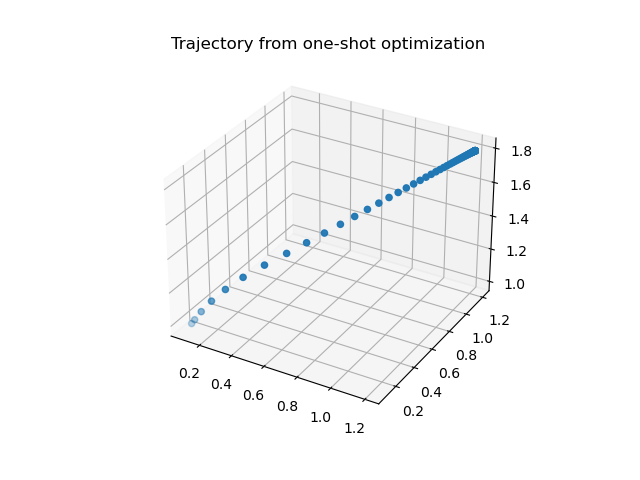

In [219]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization')


In [220]:
pos_err = np.linalg.norm(X_trj[0:3,-1]-xf[0:3])
pos_err

5.273587287438445e-06

## Running the above optimizaiton but in a receding-horizon fashion:
In this case, we relax the terminal state constraint and impose a terminal state cost into the objective function. The reason is that each optimization step is solved over a control horizon, and it's not possible that the drone reaches its goal after each control horizon (which keeps shifting forward)

In [7]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost
    # return total_stage_cost

In [8]:
x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0])
xf = np.array([1.3, 1.1, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000

# u_ref = np.zeros((3,1))
u_ref = np.array([0,0,9.8])

In [9]:
n_agents = 1
n_states = 6
n_inputs=  3

In [17]:
def solve_rhc(x0,xf,u_ref,N,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 100,"print_level":0}
    
    opti = Opti()
    M = 100 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    
    f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)
    
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
    
        X = opti.variable(6,N+1)
        U = opti.variable(3,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps

        opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
        opti.subject_to(0.4<=X[2,:])

        opti.subject_to(X[0,:]<=3) # p_x is limited
        opti.subject_to(-3<=X[0,:])

        opti.subject_to(X[1,:]<=3) # p_y is limited
        opti.subject_to(-3<=X[1,:])
        
        opti.subject_to(X[3,:] <=5) #Vx is limited
        opti.subject_to(0 <= X[3,:])
        
        opti.subject_to(X[4,:] <=5) #Vy is limited
        opti.subject_to(0 <= X[4,:])
        
        opti.subject_to(X[5,:] <=5) #Vz is limited
        opti.subject_to(0 <= X[5,:])

        opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
        opti.subject_to(-np.pi/6<=U[0,:])

        opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
        opti.subject_to(-np.pi/6<=U[1,:])

        opti.subject_to(U[2,:]<=20) # tau is limited
        opti.subject_to(0<=U[2,:]) #minimum force keeps the drone at hover

        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)

        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        J_list.append(sol.value(cost_fun))
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        if abs(J_list[i]-J_list[i-1]) <= 1 :
            print(f'Terminated! at i = {i}')
            break
        
        
    return X_full,U_full, t
    

In [18]:
from time import perf_counter

In [19]:
N = 5
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  44.80us (  3.20us)        14
       nlp_g  |        0 (       0) 100.70us (  7.19us)        14
  nlp_grad_f  |        0 (       0)  55.30us (  3.69us)        15
  nlp_hess_l  |        0 (       0)  68.80us (  5.29us)        13
   nlp_jac_g  |        0 (       0) 100.10us (  6.67us)        15
       total  |  15.62ms ( 15.62ms)  14.56ms ( 14.56ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  44.50us (  2.78us)        16
       nlp_g  |        0 (       0) 129.80us (  8.11us)        16
  nlp_grad_f  |        0 (       0)  56.60us (  3.33us)        17
  nlp_hess_l  |        0 (       0) 100.50us (  6.70us)        15
   nlp_jac_g  |        0 (       0) 157.10us (  9.24us)        17
       total  |  15.62ms ( 15.62ms)  25.04ms ( 25.04ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

In [20]:
x_trj.shape

(15, 6)

Text(0.5, 0.92, 'Trajectory with receding horizon')

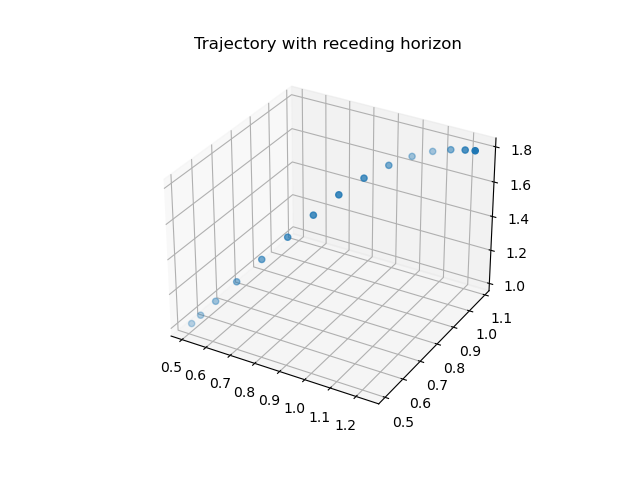

In [21]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_trj[:,0],x_trj[:,1],x_trj[:,2])
ax.set_title('Trajectory with receding horizon')

In [22]:
pos_err = np.linalg.norm(x_trj[-1,0:3]-xf[0:3])

In [23]:
pos_err  #not bad!


0.0683399851879715

## Running 3 drones in a centralized fashion:

In [24]:
x0,xf = paper_setup_3_quads()

In [25]:
xf.shape

(18, 1)

In [26]:
g = 9.81

In [27]:
n_agents = 3
n_states = 6
n_inputs=  3


# Qs = [Q] * n_agents
# Rs = [R] * n_agents
# Qfs = [Qf] * n_agents
# x_dims = [n_states]*n_agents
# u_dims = [n_inputs]*n_agents

In [28]:
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])
Q = np.diag([5,5,5,1,1,1,5,5,5,1,1,1,5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

In [29]:
max_input = np.array([[theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max]])

min_input = np.array([[theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min]])

max_state_upper = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
    
max_state_lower = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

In [30]:
max_input.shape

(9, 1)

In [31]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [32]:
eps = 1e-3

In [33]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g) #dx/dt = f(x,u)

In [69]:
def solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 1000,"print_level":0}
    
    
    M = 200 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    x_dims = [n_states]*n_agents
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.05
    
    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1)  and (i < M):
        
        
        opti = Opti()
        
        X = opti.variable(n_x,N+1)
        U = opti.variable(n_u,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps
            
            #Constraints on inputs:
            for j in range(max_input.shape[0]):
                # print(U[j,k].shape,max_input[j].shape)
                opti.subject_to(U[j,k] <= max_input[j] )
                opti.subject_to(min_input[j] <= U[j,k] )
                
       #Hard-coding collision avoidance constraints:
        # for k in range(N+1):    
        #     #Collision avoidance: 
        #     opti.subject_to(-sqrt((X[0,k]-X[6,k])**2+ (X[1,k]-X[7,k])**2 +(X[2,k]-X[8,k])**2 + eps)  <= -0.5)
        #     opti.subject_to(-sqrt((X[0,k]-X[12,k])**2 +(X[1,k]-X[13,k])**2 +(X[2,k]-X[14,k])**2 + eps) <= -0.5)
        #     opti.subject_to(-sqrt((X[12,k]-X[6,k])**2 +(X[13,k]-X[7,k])**2 +(X[14,k]-X[8,k])**2 + eps) <= -0.5)
        
        #collision avoidance constraints
        for k in range(N+1):
            distances = compute_pairwise_distance_Sym(X[:,k], x_dims)
            for n in range(len(distances)):
                opti.subject_to(distances[n] >= 0.5)
                
            #constraints on states:
            for m in range(max_state_lower.shape[0]):

                opti.subject_to(X[m,k]<= max_state_upper[m] )
                opti.subject_to(max_state_lower[m] <= X[m,k])

            
        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        # print(opti.debug.value)
        x0 = sol.value(X)[:,1].reshape(-1,1)
        # print(x0.shape)
        u_sol = sol.value(U)[:,0]
        
        J_list.append(sol.value(cost_fun))
        print(f'current objective function value is {sol.value(cost_fun)}')
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        # print(opti.variable) #print this to check the optimization parameters for each control horizon
        
        if abs(J_list[i]-J_list[i-1]) <= 1.0 :
            print(f'Terminated! at i = {i}')
            break
            
        
    return X_full,U_full, t

In [35]:
N = 15
t0 = perf_counter()
n_agents =3
n_states=6
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 228.60us (  6.35us)        36
       nlp_g  |        0 (       0) 835.60us ( 23.21us)        36
  nlp_grad_f  |        0 (       0) 301.80us (  8.88us)        34
  nlp_hess_l  |        0 (       0)   1.08ms ( 33.72us)        32
   nlp_jac_g  |        0 (       0)   1.11ms ( 32.61us)        34
       total  | 218.75ms (218.75ms) 207.95ms (207.95ms)         1
current objective function value is 3208.3983588182737
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 304.60us (  7.81us)        39
       nlp_g  |        0 (       0) 990.10us ( 25.39us)        39
  nlp_grad_f  |        0 (       0) 386.40us ( 10.17us)        38
  nlp_hess_l  |        0 (       0)   1.31ms ( 36.39us)        36
   nlp_jac_g  |        0 (       0)   1.36ms ( 35.84us)        38
       total  | 250.00ms (250.00ms) 247.12ms (247.12ms)         1
current objective fun

In [21]:
plt.close('all')

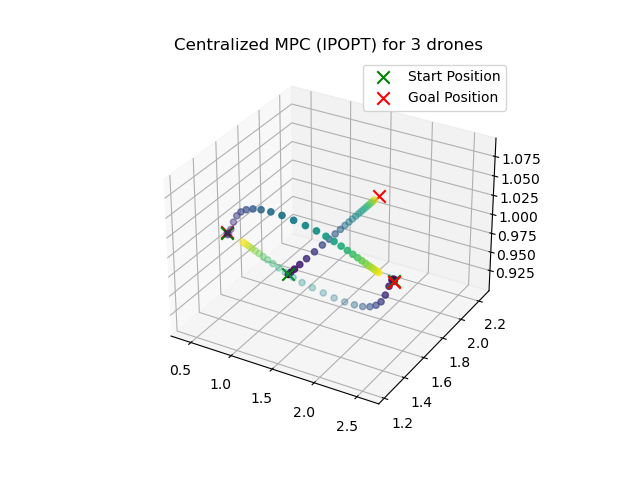

In [37]:
plt.figure()
%matplotlib ipympl
util.plot_solve(x_trj,6.2, xf, [6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 3 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);

plt.savefig('results/Centralized MPC (IPOPT) for 3 drones.png')

## 5 Drones in centralized fashion

In [51]:
#5 drones:
x0 = np.array([[-0.182, -0.545,  1.161,  0.   ,  0.   ,  0.   ,  1.335,  1.484,
         0.5  ,  0.   ,  0.   ,  0.   , -0.97 , -0.831,  2.295,  0.   ,
         0.   ,  0.   , -1.144, -1.193,  1.7  ,  0.   ,  0.   ,  0.   ,
         0.961,  1.085,  0.88 ,  0.   ,  0.   ,  0.   ]]).T
xf = np.array([[-1.751,  0.674, -1.193,  0.   ,  0.   ,  0.   ,  1.769,  0.102,
         2.998,  0.   ,  0.   ,  0.   , -1.452, -0.02 , -1.11 ,  0.   ,
         0.   ,  0.   ,  0.34 , -0.993, -0.832,  0.   ,  0.   ,  0.   ,
         1.094,  0.237,  0.137,  0.   ,  0.   ,  0.   ]]).T

u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,g,0,0,g])

n_agents = 5
n_states = 6
n_inputs=  3
Q = np.diag([5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

In [52]:
max_input_base = np.array([[theta_max], [phi_max], [tau_max]])
min_input_base = np.array([[theta_min], [phi_min], [tau_min]])
max_state_base = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
min_state_base = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

In [53]:
max_input = np.tile(max_input_base,5)
min_input = np.tile(min_input_base,5)

max_state = np.tile(max_state_base,5)
min_state = np.tile(min_state_base,5)

In [54]:
x0.shape

(30, 1)

In [55]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                        x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
                        x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g) #dx/dt = f(x,u)

In [56]:
N = 15
t0 = perf_counter()

x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   1.14ms ( 11.28us)       101
       nlp_g  |        0 (       0)   5.05ms ( 50.00us)       101
  nlp_grad_f  |        0 (       0)   1.32ms ( 17.09us)        77
  nlp_hess_l  |  62.50ms (781.25us)   6.68ms ( 83.50us)        80
   nlp_jac_g  |  62.50ms (744.05us)   5.62ms ( 66.90us)        84
       total  |   5.31 s (  5.31 s)   1.06 s (  1.06 s)         1
current objective function value is 6539.473362437575
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   1.16ms ( 10.67us)       109
       nlp_g  |  62.50ms (573.39us)   4.46ms ( 40.91us)       109
  nlp_grad_f  |        0 (       0)   1.51ms ( 14.79us)       102
  nlp_hess_l  |        0 (       0)   7.66ms ( 75.07us)       102
   nlp_jac_g  |        0 (       0)   6.70ms ( 63.18us)       106
       total  |   6.81 s (  6.81 s)   1.22 s (  1.22 s)         1
current objective func

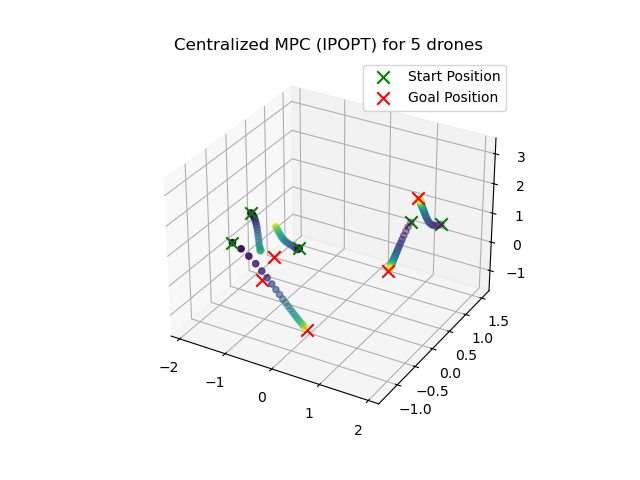

In [57]:
%matplotlib ipympl
plt.figure()

util.plot_solve(x_trj, 2857, xf, [6,6,6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 5 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Centralized MPC (IPOPT) for 5 drones.png')

## 10 Drones in centralized fashion:

In [58]:
x0 = np.array([[ 0.357,  0.799,  1.504,  0.   ,  0.   ,  0.   ,  2.172,  2.283,
         1.436,  0.   ,  0.   ,  0.   , -0.085,  0.577,  2.433,  0.   ,
         0.   ,  0.   ,  0.378,  0.254,  2.488,  0.   ,  0.   ,  0.   ,
         0.184,  0.344,  2.399,  0.   ,  0.   ,  0.   ,  2.094,  2.089,
         1.304,  0.   ,  0.   ,  0.   , -2.219, -3.09 ,  1.487,  0.   ,
         0.   ,  0.   , -0.6  , -0.406,  1.319,  0.   ,  0.   ,  0.   ,
        -2.059, -3.279,  1.48 ,  0.   ,  0.   ,  0.   , -0.222,  0.43 ,
         2.325,  0.   ,  0.   ,  0.   ]]).T

xf = np.array([[ 1.115,  1.749,  3.871,  0.   ,  0.   ,  0.   ,  0.653,  1.288,
         1.529,  0.   ,  0.   ,  0.   , -1.373, -0.243,  2.488,  0.   ,
         0.   ,  0.   , -1.314,  0.229,  1.771,  0.   ,  0.   ,  0.   ,
         1.735,  1.558,  2.081,  0.   ,  0.   ,  0.   ,  0.852, -1.583,
         2.264,  0.   ,  0.   ,  0.   ,  0.387, -1.5  ,  1.685,  0.   ,
         0.   ,  0.   , -1.26 , -0.697,  2.494,  0.   ,  0.   ,  0.   ,
        -0.213, -0.138,  1.545,  0.   ,  0.   ,  0.   , -0.582, -0.663,
         2.518,  0.   ,  0.   ,  0.   ]]).T

In [59]:
u_ref_base = np.array([0,0,g])
u_ref = np.tile(u_ref_base,10)

In [60]:
u_ref

array([0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  ,
       9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  ,
       0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81])

In [61]:
n_agents = 10
n_states = 6
n_inputs=  3
Q = np.diag([5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

In [62]:
max_input = np.tile(max_input_base,n_agents)
min_input = np.tile(min_input_base,n_agents)

max_state = np.tile(max_state_base,n_agents)
min_state = np.tile(min_state_base,n_agents)

In [63]:
x_dims = [n_states]*n_agents
x_dims


[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [64]:
x0.shape

(60, 1)

In [65]:
xf.shape

(60, 1)

In [66]:
u_ref.shape

(30,)

In [67]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                        x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
                        x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g,
                        x[33],x[34],x[35], g*tan(u[15]), -g*tan(u[16]), u[17]-g,
                        x[39],x[40],x[41], g*tan(u[18]), -g*tan(u[19]), u[20]-g,
                        x[45],x[46],x[47], g*tan(u[21]), -g*tan(u[22]), u[23]-g,
                        x[51],x[52],x[53], g*tan(u[24]), -g*tan(u[25]), u[26]-g,
                        x[57],x[58],x[59], g*tan(u[27]), -g*tan(u[28]), u[29]-g) #dx/dt = f(x,u)

In [70]:
N = 15
t0 = perf_counter()
# print(x0.shape,xf.shape)
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   2.74ms ( 17.82us)       154
       nlp_g  |  15.62ms (101.46us)  12.22ms ( 79.35us)       154
  nlp_grad_f  |        0 (       0)   1.49ms ( 27.08us)        55
  nlp_hess_l  |  15.62ms (183.82us)  18.64ms (219.34us)        85
   nlp_jac_g  |  46.88ms (393.91us)  16.35ms (137.38us)       119
       total  |   1.69 s (  1.69 s)   1.71 s (  1.71 s)         1


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:997: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

## Now run the above optimization problem in distributed fashion using game-potential formulation:

In [93]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1): #summing over horizon
        for i in range(X.shape[0]):#element-wise multiplication
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]): #summing over horizon
        for i in range(U.shape[0]):#element-wise multiplication
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [94]:
def generate_min_max_input(inputs_dict,n_inputs):
    
    theta_max = np.pi/6
    phi_max = np.pi/6

    v_max = 3
    v_min = -3

    theta_min = -np.pi/6
    phi_min = -np.pi/6

    tau_max = 15
    tau_min = 0
    
    n_agents = [u.shape[0] // n_inputs for u in inputs_dict.values()]

    u_min = np.array([[theta_min, phi_min, tau_min]])
    u_max = np.array([[theta_max, phi_max, tau_max]])
    
    return [
        (np.tile(u_min, n_agents_i), np.tile(u_max, n_agents_i)) 
        for n_agents_i in n_agents
        ]

  

In [95]:
def generate_min_max_state(states_dict,n_states):
    
    x_min = -5
    x_max = 5

    y_min = -5
    y_max = 5

    z_min = 0
    z_max = 3.0
    
    n_agents = [x.shape[0] // n_states for x in states_dict.values()]
    x_min = np.array([[x_min, y_min, z_min, v_min, v_min , v_min]])
    x_max = np.array([[x_max, y_max, z_max, v_max, v_max, v_max]])
    
    return [
        (np.tile(x_min, n_agents_i), np.tile(x_max, n_agents_i)) 
        for n_agents_i in n_agents
        ]

  

In [96]:
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

x0,xf = paper_setup_3_quads()
n_agents = 3
n_states=6
n_inputs=3
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents
radius=0.5
ids = [100 + i for i in range(n_agents)]

dt = 0.1

In [97]:
# def generate_f(x_dims_local):
    
#     # NOTE: Assume homogeneity of agents.
#     n_agents = len(x_dims_local)
#     n_states = x_dims_local[0] // n_agents
#     n_controls = 3
    
#     def f(x, u):
#         x_dot = cs.MX.zeros(x.numel())
#         for i_agent in range(n_agents):
#             i_xstart = i_agent * n_states
#             i_ustart = i_agent * n_controls
#             x_dot[i_xstart:i_xstart + n_states] = cs.vertcat(
#                 x[i_xstart + 3: i_xstart + 6],
#                 g*cs.tan(u[i_ustart]), -g*cs.tan(u[i_ustart+1]), u[i_ustart+2] - g
#                 )
            
#         return x_dot
    
#     return f    

In [98]:
def generate_f(x_dims_local):
    
    
    if len(x_dims_local) == 1:
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g)

    if len(x_dims_local) == 2:
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,\
                                x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g)

    if len(x_dims_local) == 3:

        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                                x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                                x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g) #dx/dt = f(x,u)
        
        
    if len(x_dims_local) == 4:
        
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                                x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                                x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                                x[21], x[22],x[23], g*tan(u[9]),-g*tan(u[10]),u[11]-g)
        
    if len(x_dims_local) == 5:

        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                        x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
                        x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g) #dx/dt = f(x,u)
        
    if len(x_dims_local) == 6:
        
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                                x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
                                x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
                                x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
                                x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
                               x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g)
        
    if len(x_dims_local) == 7:
        
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                                x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
                                x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
                                x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
                                x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
                               x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g,
                                x[39],x[40],x[41],g*tan(u[18]),-g*tan(u[19]),u[20]-g)
        
    if len(x_dims_local) == 8:
        
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                                x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
                                x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
                                x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
                                x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
                               x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g,
                                x[39],x[40],x[41],g*tan(u[18]),-g*tan(u[19]),u[20]-g,
                                 x[45],x[46],x[47],g*tan(u[21]),-g*tan(u[22]),u[23]-g)
        
    if len(x_dims_local) == 9:
        
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                                x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
                                x[15],x[16],x[17],g*tan(u[6]),-g*tan(u[7]), u[8]-g,
                                x[21],x[22],x[23],g*tan(u[9]),-g*tan(u[10]),u[11]-g,
                                x[27],x[28],x[29],g*tan(u[12]),-g*tan(u[13]),u[14]-g,
                               x[33],x[34],x[35],g*tan(u[15]),-g*tan(u[16]),u[17]-g,
                                x[39],x[40],x[41],g*tan(u[18]),-g*tan(u[19]),u[20]-g,
                                 x[45],x[46],x[47],g*tan(u[21]),-g*tan(u[22]),u[23]-g,
                               x[51],x[52],x[53],g*tan(u[24]),-g*tan(u[25]),u[26]-g)
        
    if len(x_dims_local) == 10:
        
        f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                        x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
                        x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g,
                        x[33],x[34],x[35], g*tan(u[15]), -g*tan(u[16]), u[17]-g,
                        x[39],x[40],x[41], g*tan(u[18]), -g*tan(u[19]), u[20]-g,
                        x[45],x[46],x[47], g*tan(u[21]), -g*tan(u[22]), u[23]-g,
                        x[51],x[52],x[53], g*tan(u[24]), -g*tan(u[25]), u[26]-g,
                        x[57],x[58],x[59], g*tan(u[27]), -g*tan(u[28]), u[29]-g)
        
        
    return f
    

In [111]:
def solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids):

    x_dims = [n_states]*n_agents
    u_dims = [n_inputs]*n_agents
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 1000,"print_level":0}
    
    M = 100 # this is the entire fixed horizon
    
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    loop = 0
    dt = 0.1
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))

    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1) and (loop < M):
        # print(f'dis to goal is {distance_to_goal(x0,xf,n_agents,n_states)}')
        ######################################################################
        #Determine sub problems to solve:
        
        #compute interaction graph at the current time step:
        if loop > 0 :
            print(f're-optimizing at {x0.T}')
            
        rel_dists = compute_pairwise_distance(x0, x_dims, n_d=3)

        graph = define_inter_graph_threshold(x0, radius, x_dims, ids)
      
        print(f'current interaction graph is {graph}, the pairwise distances between each agent is {rel_dists}')
        #x0 is updated until convergence (treat x0 as the combined CURRENT state)
        
        #break up the problem into potential-game sub-problems at every outer iteration
        split_problem_states_initial = split_graph(x0.T,x_dims,graph)
        # print(split_problem_states_initial)
        split_problem_states = split_graph(xf.T,x_dims,graph)
        split_problem_inputs = split_graph(u_ref.reshape(-1,1).T,u_dims,graph)
        
        #Initiate different instances of Opti() object
        #Each Opti() object corresponds to a subproblem (there is NO central node)
        #Note that when 2 agents are combined into a single problem, we have 2 copies of the same sub problem
        ########################################################################
        #Setting up the solvers:
        d = {}
        states = {}
        inputs = {}
        cost_fun_list = [] 
        
        d = {} #dictionary holding Opti() objects (or subproblems)
        states = {} #dictionary holding symbolic state trajectory for each sub-problem
        inputs = {} ##dictionary holding symbolic input trajectory for each sub-problem
        
        for i,j in enumerate(split_problem_states_initial):
            d['opti_{0}'.format(i)] = Opti()
            states['X_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N+1) 

        for i,j in enumerate(split_problem_inputs):
            inputs['U_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N)
        
        #Storing objective functions for each sub-problem into a list:
        for i in range(len(split_problem_states_initial)):
            cost_fun_list.append(objective(states[f'X_{i}'],\
                                   inputs[f'U_{i}'],\
                                   split_problem_inputs[i].reshape(-1,),\
                                   split_problem_states[i].reshape(-1,1),\
                                   np.eye(split_problem_states_initial[i].shape[1])*100,
                                   np.eye(split_problem_inputs[i].reshape(-1,).shape[0])*0.1,
                                   np.eye(split_problem_states_initial[i].shape[1])*1000))
        
        min_max_input_list = generate_min_max_input(inputs,n_inputs)
        min_max_state_list = generate_min_max_state(states,n_states)
        
        ##########################################################################
        #Solve each sub-problem in a sequential manner:
        #TODO: parallel computation for better speed?
    
        
        objective_val = 0
        X_dec = np.zeros((1, n_x))
        U_dec = np.zeros((1, n_u))
        for di, statesi, inputsi, costi, state_boundsi, input_boundsi, (prob,ids_), count in zip(
            d.values(), 
            states.values(), 
            inputs.values(), 
            cost_fun_list, 
            min_max_state_list,
            min_max_input_list,
            graph.items(),
            range(len(d))): #loop over sub-problems
            
            
            print(f'Solving the {count}th sub-problem at iteration {loop}, t = {t}')
            
   
            min_states, max_states = state_boundsi
            min_inputs, max_inputs = input_boundsi

            di.minimize(costi)
            
            n_states_local = statesi.shape[0] #each subproblem has different number of states
            # print(f'n_states_local:{n_states_local}')
            n_inputs_local = inputsi.shape[0]
            x_dims_local = [int(n_states)]*int(n_states_local/n_states)
            
            print(f'current sub-problem has state dimension : {x_dims_local}')
            # u_dims_local =  [int(n_inputs_local/(n_inputs_local/n_inputs))]*int(n_inputs_local/n_inputs)
            #i.e, [6,6] if the current sub-problem has 2 agents combined, or [6,6,6] if 3 agents are combined
            
            f = generate_f(x_dims_local)
            
            for k in range(N): #loop over control intervals
                # Runge-Kutta 4 integration
 
                k1 = f(statesi[:,k],         inputsi[:,k])
                k2 = f(statesi[:,k]+dt/2*k1, inputsi[:,k])
                k3 = f(statesi[:,k]+dt/2*k2, inputsi[:,k])
                k4 = f(statesi[:,k]+dt*k3,   inputsi[:,k])
                x_next = statesi[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
                
                di.subject_to(statesi[:,k+1]==x_next) # close the gaps
                
                di.subject_to(inputsi[:,k] <= max_inputs.T)
                di.subject_to(min_inputs.T <= inputsi[:,k])
            
            for k in range(N+1):
                
                di.subject_to(statesi[:,k] <= max_states.T)
                di.subject_to(min_states.T <= statesi[:,k])
                
                # DBG
                # distances, d_test = compute_pairwise_distance_Sym(statesi[:,k], x_dims_local)
                # print(distances, d_test)
                
                #collision avoidance over control horizon (only if the current sub-problem contains the states of more than 1 agent):

                if len(x_dims_local) !=1:
                    distances= compute_pairwise_distance_Sym(statesi[:,k], x_dims_local)
                    for n in distances:
                        di.subject_to(n >= 0.5)
        
            
            #equality constraints for initial condition:
            di.subject_to(statesi[:,0] == split_problem_states_initial[count].reshape(-1,1))
            
            di.solver("ipopt",p_opts,
                        s_opts) 
            
            
            sol = di.solve()
          
            objective_val += sol.value(costi)
            print(f'objective value for the {count}th subproblem at iteration {loop} is {sol.value(costi)}')
            # print(sol.value(statesi).shape)
            x0_local = sol.value(statesi)[:,1]

            u_sol_local = sol.value(inputsi)[:,0]

            i_prob = ids_.index(prob)

            # X_dec[0,:] = x0.reshape(1,-1)
            
            X_dec[:,count*n_states:(count+1)*n_states] = x0_local[i_prob*n_states:(i_prob+1)*n_states]
            U_dec[:,count*n_inputs:(count+1)*n_inputs] = u_sol_local[i_prob*n_inputs:(i_prob+1)*n_inputs]
            
        #PROBLEM RIGHT HERE!!! somehow I get a bunch of unexpected zeros at this step (in the current solution x0)
        x0 = X_dec.reshape(-1,1)
        print(f'current collected solution is {x0.T}#')
        
        # print(x0)
        J_list.append(objective_val) #collect aggregate objective function from all sub-problems after each control horizon is over
        print(f'current combined objective value is {objective_val}##########################\n')
        #Store the trajectory
        
        X_full = np.r_[X_full, X_dec.reshape(1,-1)]
        # print(X_full.shape)
        # x0 = X_full[loop,:].reshape(-1,1)

        U_full = np.r_[U_full, U_dec.reshape(1,-1)]
        
        t += dt
        loop +=1
        
      
        if abs(J_list[loop]-J_list[loop-1]) <= 1 :
            print(f'Terminated! at loop = {loop}')
            break
            
        # if loop == 5:
        #     break
            
    return X_full,U_full, t
    
    

In [112]:
ids = [100 + i for i in range(n_agents)]
N = 15

In [101]:
t0 = perf_counter()
X_full,U_full, t= solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)
tf = perf_counter()
print(f'\n Total run time for distributed RHC is {tf-t0}')

determining interaction graph with the following pair-wise distance : [[2.   1.02 1.02]]
current interaction graph is {100: [100], 101: [101], 102: [102]}, the pairwise distances between each agent is [[2.   1.02 1.02]]
Solving the 0th sub-problem at iteration 0, t = 0
current sub-problem has state dimension : [6]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  61.10us (  3.59us)        17
       nlp_g  |        0 (       0) 142.20us (  8.36us)        17
  nlp_grad_f  |        0 (       0)  79.90us (  4.44us)        18
  nlp_hess_l  |        0 (       0) 141.20us (  8.82us)        16
   nlp_jac_g  |        0 (       0) 195.90us ( 10.88us)        18
       total  |  31.25ms ( 31.25ms)  32.88ms ( 32.88ms)         1
objective value for the 0th subproblem at iteration 0 is 4653.904470767384
Solving the 1th sub-problem at iteration 0, t = 0
current sub-problem has state dimension : [6]
      solver  :   t_proc      (avg)   t_wall      (

In [102]:
X_full.shape

(33, 18)

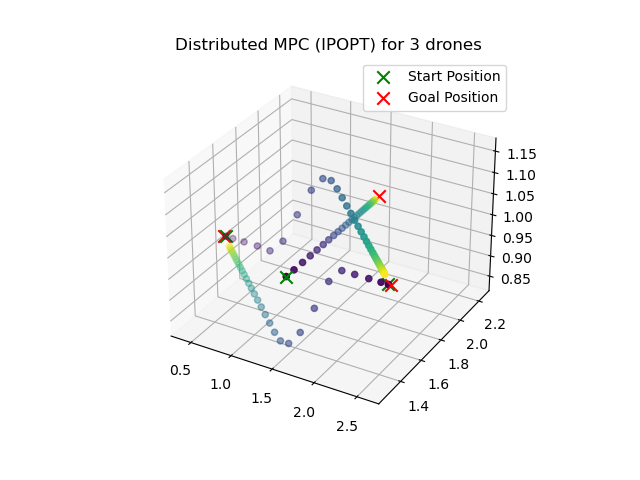

In [103]:
plt.figure()

%matplotlib ipympl
util.plot_solve(X_full, 0, xf, [6,6,6], False, n_d=3)
plt.title('Distributed MPC (IPOPT) for 3 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Distributed MPC (IPOPT) for 3 drones.png')


## 5 drones:

In [118]:
x0 = np.array([[-0.182, -0.545,  1.161,  0.   ,  0.   ,  0.   ,  1.335,  1.484,
         0.5  ,  0.   ,  0.   ,  0.   , -0.97 , -0.831,  2.295,  0.   ,
         0.   ,  0.   , -1.144, -1.193,  1.7  ,  0.   ,  0.   ,  0.   ,
         0.961,  1.085,  0.88 ,  0.   ,  0.   ,  0.   ]]).T
xf = np.array([[-1.751,  0.674, -1.193,  0.   ,  0.   ,  0.   ,  1.769,  0.102,
         2.998,  0.   ,  0.   ,  0.   , -1.452, -0.02 , -1.11 ,  0.   ,
         0.   ,  0.   ,  0.34 , -0.993, -0.832,  0.   ,  0.   ,  0.   ,
         1.094,  0.237,  0.137,  0.   ,  0.   ,  0.   ]]).T


n_agents = 5
n_states=6
n_inputs=3
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents
radius=0.5
ids = [100 + i for i in range(n_agents)]

dt = 0.1

u_ref = np.tile(u_ref_base,n_agents)

ids = [100 + i for i in range(n_agents)]
N = 15

In [124]:
t0 = perf_counter()
X_full,U_full, t= solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)
tf = perf_counter()
print(f'\n Total run time for distributed RHC is {tf-t0}')

determining interaction graph with the following pair-wise distance : [[2.533 0.838 1.16  1.991 3.267 3.649 0.547 0.402 2.72  3.102]]
current interaction graph is {100: [100, 102], 101: [101, 104], 102: [100, 102, 103], 103: [102, 103], 104: [101, 104]}, the pairwise distances between each agent is [[2.618 1.41  1.279 2.011 3.728 3.841 0.666 0.718 3.066 3.208]]
Solving the 0th sub-problem at iteration 0, t = 0
current sub-problem has state dimension : [6, 6]
inputsi is shape (6, 15)
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 114.00us (  5.18us)        22
       nlp_g  |        0 (       0) 326.40us ( 14.84us)        22
  nlp_grad_f  |        0 (       0) 165.40us (  7.19us)        23
  nlp_hess_l  |        0 (       0) 408.90us ( 19.47us)        21
   nlp_jac_g  |        0 (       0) 495.80us ( 21.56us)        23
       total  |  93.75ms ( 93.75ms)  91.41ms ( 91.41ms)         1
objective value for the 0th subproblem at iteratio

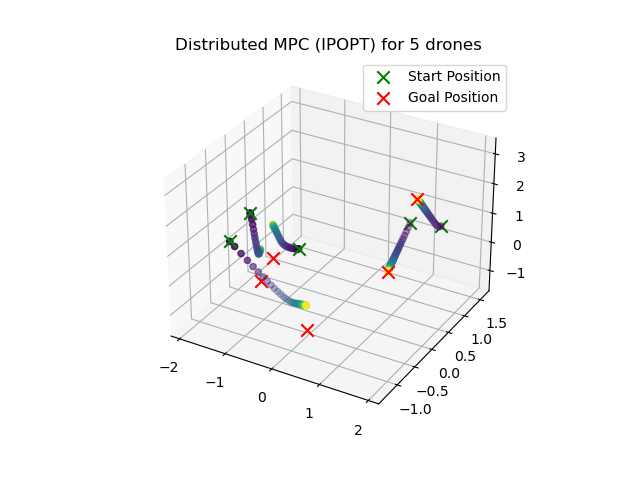

In [125]:
plt.figure()

%matplotlib ipympl
util.plot_solve(X_full, 0, xf, [6,6,6,6,6], False, n_d=3)
plt.title('Distributed MPC (IPOPT) for 5 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Distributed MPC (IPOPT) for 5 drones.png')

## Distributed for 10 drones:

In [136]:
x0 = np.array([[ 0.357,  0.799,  1.504,  0.   ,  0.   ,  0.   ,  2.172,  2.283,
         1.436,  0.   ,  0.   ,  0.   , -0.085,  0.577,  2.433,  0.   ,
         0.   ,  0.   ,  0.378,  0.254,  2.488,  0.   ,  0.   ,  0.   ,
         0.184,  0.344,  2.399,  0.   ,  0.   ,  0.   ,  2.094,  2.089,
         1.304,  0.   ,  0.   ,  0.   , -2.219, -3.09 ,  1.487,  0.   ,
         0.   ,  0.   , -0.6  , -0.406,  1.319,  0.   ,  0.   ,  0.   ,
        -2.059, -3.279,  1.48 ,  0.   ,  0.   ,  0.   , -0.222,  0.43 ,
         2.325,  0.   ,  0.   ,  0.   ]]).T
xf = np.array([[ 1.115,  1.749,  3.871,  0.   ,  0.   ,  0.   ,  0.653,  1.288,
         1.529,  0.   ,  0.   ,  0.   , -1.373, -0.243,  2.488,  0.   ,
         0.   ,  0.   , -1.314,  0.229,  1.771,  0.   ,  0.   ,  0.   ,
         1.735,  1.558,  2.081,  0.   ,  0.   ,  0.   ,  0.852, -1.583,
         2.264,  0.   ,  0.   ,  0.   ,  0.387, -1.5  ,  1.685,  0.   ,
         0.   ,  0.   , -1.26 , -0.697,  2.494,  0.   ,  0.   ,  0.   ,
        -0.213, -0.138,  1.545,  0.   ,  0.   ,  0.   , -0.582, -0.663,
         2.518,  0.   ,  0.   ,  0.   ]]).T


n_agents = 10
n_states=6
n_inputs=3
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents
radius=0.5
ids = [100 + i for i in range(n_agents)]

dt = 0.01

u_ref = np.tile(u_ref_base,n_agents)

ids = [100 + i for i in range(n_agents)]
N = 5

In [137]:
u_ref

array([0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  ,
       9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81, 0.  ,
       0.  , 9.81, 0.  , 0.  , 9.81, 0.  , 0.  , 9.81])

In [138]:
t0 = perf_counter()
X_full,U_full, t= solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)
tf = perf_counter()
print(f'\n Total run time for distributed RHC is {tf-t0}')

determining interaction graph with the following pair-wise distance : [[2.344 0.495 0.545 0.487 2.164 4.665 1.539 4.74  0.687 2.829 2.708 2.777
  0.209 6.939 3.862 6.988 3.027 0.565 0.356 2.652 4.243 1.11  4.332 0.201
  0.214 2.512 4.234 1.18  4.292 0.625 2.587 4.191 1.085 4.261 0.415 6.74
  3.672 6.787 2.849 3.134 0.248 4.047 3.222 0.917 4.139]]
current interaction graph is {100: [100, 102, 103, 104, 109], 101: [101, 105], 102: [100, 102, 103, 104, 109], 103: [100, 102, 103, 104, 109], 104: [100, 102, 103, 104, 109], 105: [101, 105], 106: [106, 108], 107: [107, 109], 108: [106, 108], 109: [100, 102, 103, 104, 107, 109]}, the pairwise distances between each agent is [[2.345 1.052 1.125 1.019 2.173 4.665 1.55  4.74  1.07  3.    2.906 2.939
  0.247 6.939 3.864 6.989 3.155 0.567 0.357 2.883 4.347 1.572 4.435 0.228
  0.232 2.777 4.351 1.661 4.409 0.646 2.809 4.289 1.531 4.359 0.422 6.742
  3.672 6.789 3.026 3.139 0.248 4.133 3.226 1.362 4.224]]
Solving the 0th sub-problem at iteration 0, t

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:997: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'